In [74]:
import pandas as pd

train = pd.read_csv("data/flight_delays_train.csv")
test= pd.read_csv("data/flight_delays_test.csv")

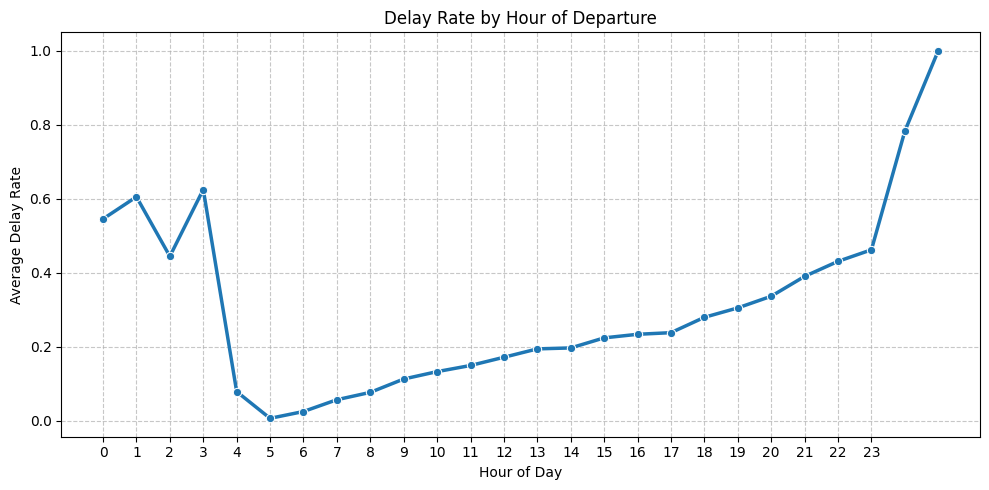

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("data/flight_delays_train.csv")

train['Delay'] = (train['dep_delayed_15min'] == 'Y').astype(int)
train['DepMinutes'] = (train['DepTime'] // 100) * 60 + (train['DepTime'] % 100)
train['DepHour'] = train['DepMinutes'] // 60
train['DayOfWeek_num'] = train['DayOfWeek'].str.split('-', expand=True)[1].astype(int)


plt.figure(figsize=(10, 5))
hourly_delay = train.groupby('DepHour')['Delay'].mean().reset_index()
sns.lineplot(data=hourly_delay, x='DepHour', y='Delay', marker='o', linewidth=2.5)
plt.title('Delay Rate by Hour of Departure')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay Rate')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


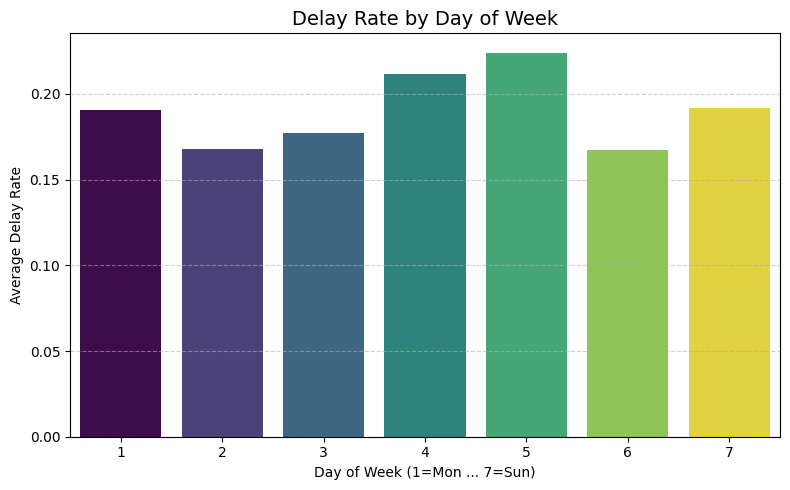

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
dow_delay = train.groupby('DayOfWeek_num')['Delay'].mean().reset_index()
sns.barplot(data=dow_delay, x='DayOfWeek_num', y='Delay', hue='DayOfWeek_num', palette='viridis', legend=False)
plt.title('Delay Rate by Day of Week', fontsize=14)
plt.xlabel('Day of Week (1=Mon ... 7=Sun)')
plt.ylabel('Average Delay Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


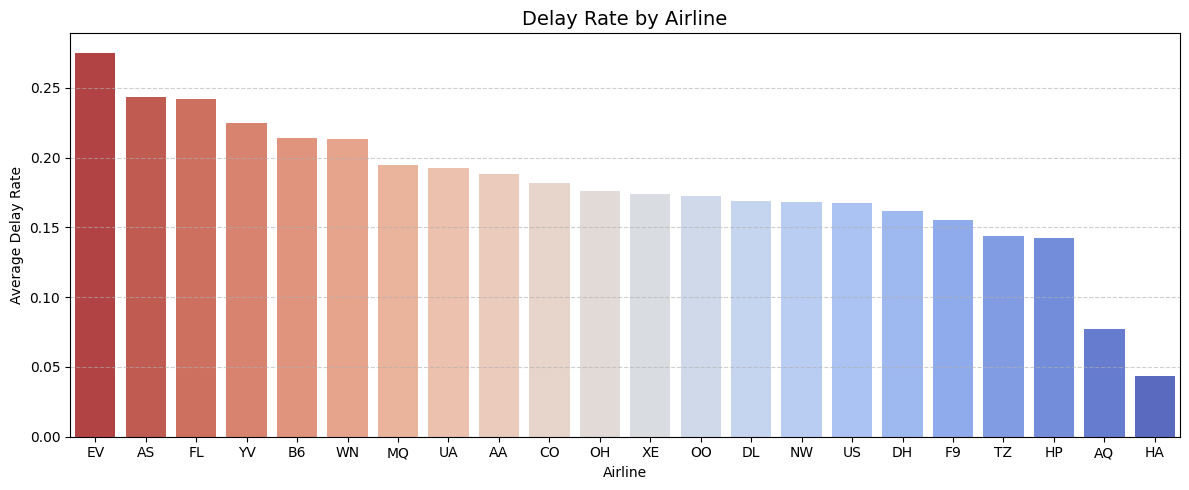

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Sort and plot
carrier_delay = train.groupby('UniqueCarrier')['Delay'].mean().sort_values(ascending=False).reset_index()

sns.barplot(
    data=carrier_delay,
    x='UniqueCarrier',
    y='Delay',
    hue='UniqueCarrier',
    palette='coolwarm_r',  
    dodge=False,
    legend=False
)

plt.title('Delay Rate by Airline', fontsize=14)
plt.xlabel('Airline')
plt.ylabel('Average Delay Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


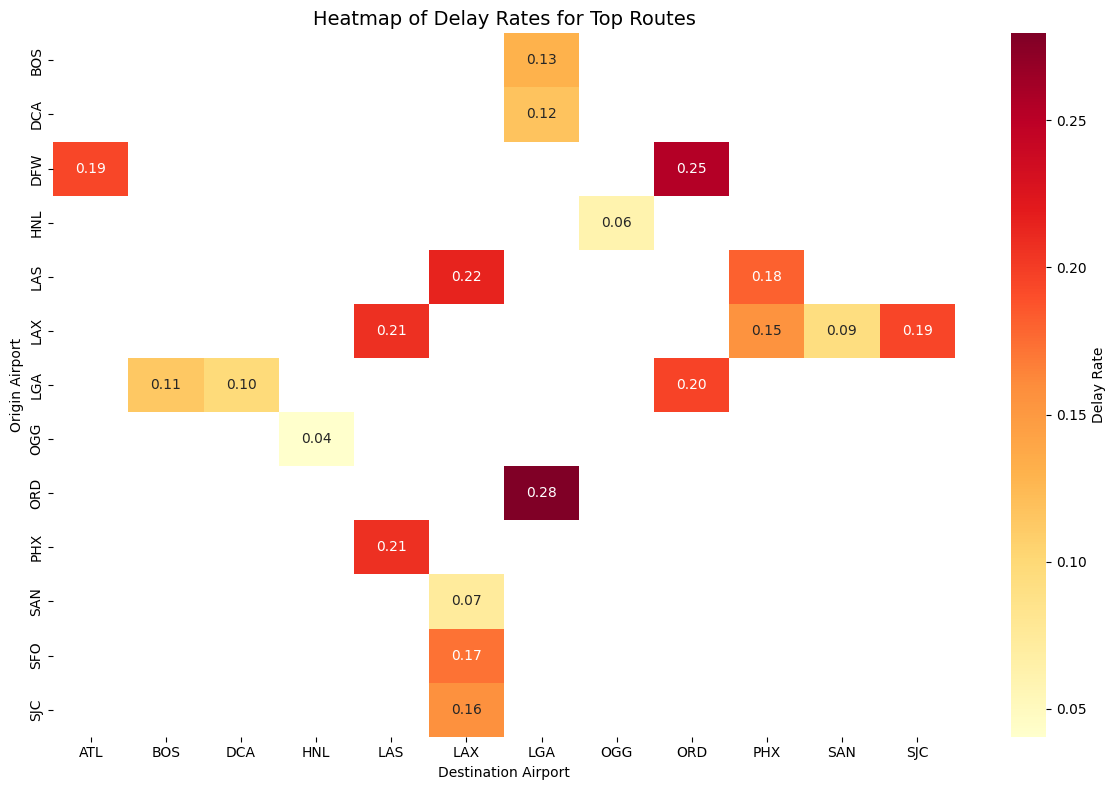

In [72]:
# Get top 20 origin-destination pairs
route_counts = train.groupby(['Origin', 'Dest']).size().reset_index(name='count')
top_routes = route_counts.sort_values('count', ascending=False).head(20)

# Filter to top routes
top_delays = train.merge(top_routes[['Origin', 'Dest']], on=['Origin', 'Dest'])
pivot = top_delays.pivot_table(index='Origin', columns='Dest', values='Delay', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Delay Rate'})
plt.title('Heatmap of Delay Rates for Top Routes', fontsize=14)
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()


In [ ]:
train["Month_num"] = (
    train["Month"]
    .str.split("-", expand=True)[1]  
    .astype(int)                     
)

test["Month_num"] = (
    test["Month"]
    .str.split("-", expand=True)[1]
    .astype(int)
)

train["Day_num"] = (
    train["DayofMonth"]
    .str.split("-", expand=True)[1]  
    .astype(int)                      
)

test["Day_num"] = (
    test["DayofMonth"]
    .str.split("-", expand=True)[1]
    .astype(int)
)

train["DayOfWeek_num"] = (
    train["DayOfWeek"]
    .str.split("-", expand=True)[1]  
    .astype(int)                     
)

test["DayOfWeek_num"] = (
    test["DayOfWeek"]
    .str.split("-", expand=True)[1]
    .astype(int)
)

train['DepMinutes'] = (train['DepTime'] // 100) * 60 + (train['DepTime'] % 100)
test['DepMinutes'] = (test['DepTime'] // 100) * 60 + (test['DepTime'] % 100)

import numpy as np

train['Dep_sin'] = np.sin(2 * np.pi * train['DepMinutes'] / 1440)
train['Dep_cos'] = np.cos(2 * np.pi * train['DepMinutes'] / 1440)

test['Dep_sin'] = np.sin(2 * np.pi * test['DepMinutes'] / 1440)
test['Dep_cos'] = np.cos(2 * np.pi * test['DepMinutes'] / 1440)

train['DepHour']   = train['DepMinutes'] // 60    
train['DepMinute'] = train['DepMinutes'] % 60     

test['DepHour']   = test['DepMinutes'] // 60
test['DepMinute'] = test['DepMinutes'] % 60

def tod_bin(mins):
    if mins < 360:            # 00:00–05:59
        return 'Late_Night'
    elif mins < 600:          # 06:00–09:59
        return 'Morning'
    elif mins < 840:          # 10:00–13:59
        return 'Midday'
    elif mins < 1080:         # 14:00–17:59
        return 'Afternoon'
    else:                     # 18:00–23:59
        return 'Evening'

train['TOD_bin'] = train['DepMinutes'].apply(tod_bin)
test['TOD_bin']  = test['DepMinutes'].apply(tod_bin)

train = pd.get_dummies(train, columns=['TOD_bin'], prefix='TOD')
test  = pd.get_dummies(test,  columns=['TOD_bin'], prefix='TOD')

train = pd.get_dummies(train, columns=['Month_num','DayOfWeek_num'], prefix=['M','DOW'])
test  = pd.get_dummies(test,  columns=['Month_num','DayOfWeek_num'], prefix=['M','DOW'])


drop_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime']
train = train.drop(columns=drop_cols)
test  = test.drop(columns=drop_cols)

cat_cols = ['UniqueCarrier', 'Origin', 'Dest']
train = pd.get_dummies(train, columns=cat_cols)
test  = pd.get_dummies(test, columns=cat_cols)

test = test.reindex(columns=train.columns.drop('dep_delayed_15min'), fill_value=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

#Define target and features
y = (train['dep_delayed_15min'] == 'Y').astype(int)
X = train.drop(columns=['dep_delayed_15min'])

# Align test set columns with training set
test = test.reindex(columns=X.columns, fill_value=0)

# Cross-validation on full training set
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ROC AUC scores from 5-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

# Print average and individual fold scores
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC Score: {cv_scores.mean():.4f}")

# Retrain on full data for final predictions
clf_final = RandomForestClassifier(n_estimators=100, random_state=42)
clf_final.fit(X, y)

# Predict on test data
test_probs = clf_final.predict_proba(test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'id': range(len(test)),
    'dep_delayed_15min': test_probs
})
submission.to_csv("data/submission_rf.csv", index=False)


Cross-Validation ROC AUC Scores: [0.75396287 0.7523679  0.75528419 0.73989924 0.75447315]
Mean CV ROC AUC Score: 0.7512


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Define target and features
y = (train['dep_delayed_15min'] == 'Y').astype(int)
X = train.drop(columns=['dep_delayed_15min'])

# Align test set columns with training set
test = test.reindex(columns=X.columns, fill_value=0)

# Cross-validation on full training set
clf = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# ROC AUC scores from 5-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

# Print average and individual fold scores
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC Score: {cv_scores.mean():.4f}")

# Retrain on full data for final predictions
clf.fit(X, y)

# Predict on test data
test_probs = clf.predict_proba(test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'id': range(len(test)),
    'dep_delayed_15min': test_probs
})
submission.to_csv("data/submission_XG.csv", index=False)


Cross-Validation ROC AUC Scores: [0.74659374 0.74361334 0.74523255 0.73318629 0.74746605]
Mean CV ROC AUC Score: 0.7432


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Define target and features
y = (train['dep_delayed_15min'] == 'Y').astype(int)
X = train.drop(columns=['dep_delayed_15min'])

#Align test set columns with training set
test = test.reindex(columns=X.columns, fill_value=0)

# Cross-validation on full training set
clf = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42,
    verbose=-1  # suppress LightGBM info logs
)


# ROC AUC scores from 5-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

# Print average and individual fold scores
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC Score: {cv_scores.mean():.4f}")

# Retrain on full data for final predictions
clf.fit(X, y)

# redict on test data
test_probs = clf.predict_proba(test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'id': range(len(test)),
    'dep_delayed_15min': test_probs
})
submission.to_csv("data/submission_light.csv", index=False)


Cross-Validation ROC AUC Scores: [0.7492187  0.74577759 0.74632747 0.73722944 0.75025884]
Mean CV ROC AUC Score: 0.7458


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Define target and features
y = (train['dep_delayed_15min'] == 'Y').astype(int)
X = train.drop(columns=['dep_delayed_15min'])

# Align test set columns with training set
test = test.reindex(columns=X.columns, fill_value=0)

# Define base learners and meta-learner
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]
meta_learner = LogisticRegression(max_iter=1000)

clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Cross-validation on full training set
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

# Print scores
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC Score: {cv_scores.mean():.4f}")

# Retrain on full data for final predictions
clf.fit(X, y)

# Predict on test data
test_probs = clf.predict_proba(test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'id': range(len(test)),
    'dep_delayed_15min': test_probs
})
submission.to_csv("data/submission_mixed.csv", index=False)


Cross-Validation ROC AUC Scores: [0.7548815  0.75189524 0.75582793 0.74089998 0.75531211]
Mean CV ROC AUC Score: 0.7518


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Define target and features
y = (train['dep_delayed_15min'] == 'Y').astype(int)
X = train.drop(columns=['dep_delayed_15min'])

# Align test set columns with training set
test = test.reindex(columns=X.columns, fill_value=0)

# CatBoost 
clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)

# Cross-validation on full training set
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

# Print CV results
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC Score: {cv_scores.mean():.4f}")

# Retrain on full data for final predictions
clf.fit(X, y)

# Predict on test data
test_probs = clf.predict_proba(test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    'id': range(len(test)),
    'dep_delayed_15min': test_probs
})
submission.to_csv("data/submission_catboost.csv", index=False)


Cross-Validation ROC AUC Scores: [0.7354833  0.72725095 0.73249834 0.72012523 0.73235796]
Mean CV ROC AUC Score: 0.7295
